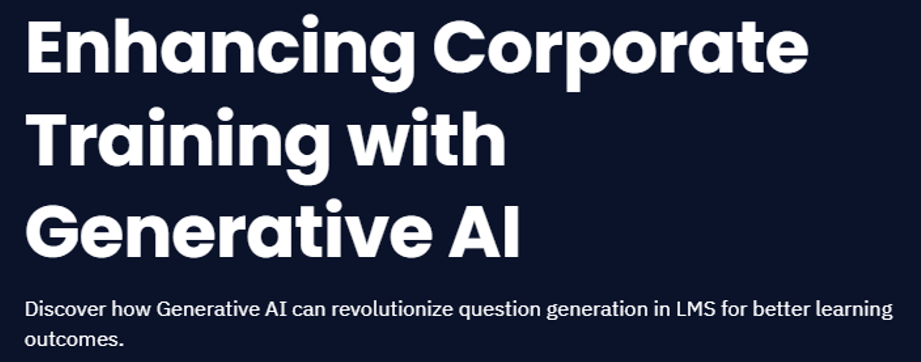

Dharmendra Pratap Singh, Praveen Kumar Gupta, Manoj Kumar Manmathan


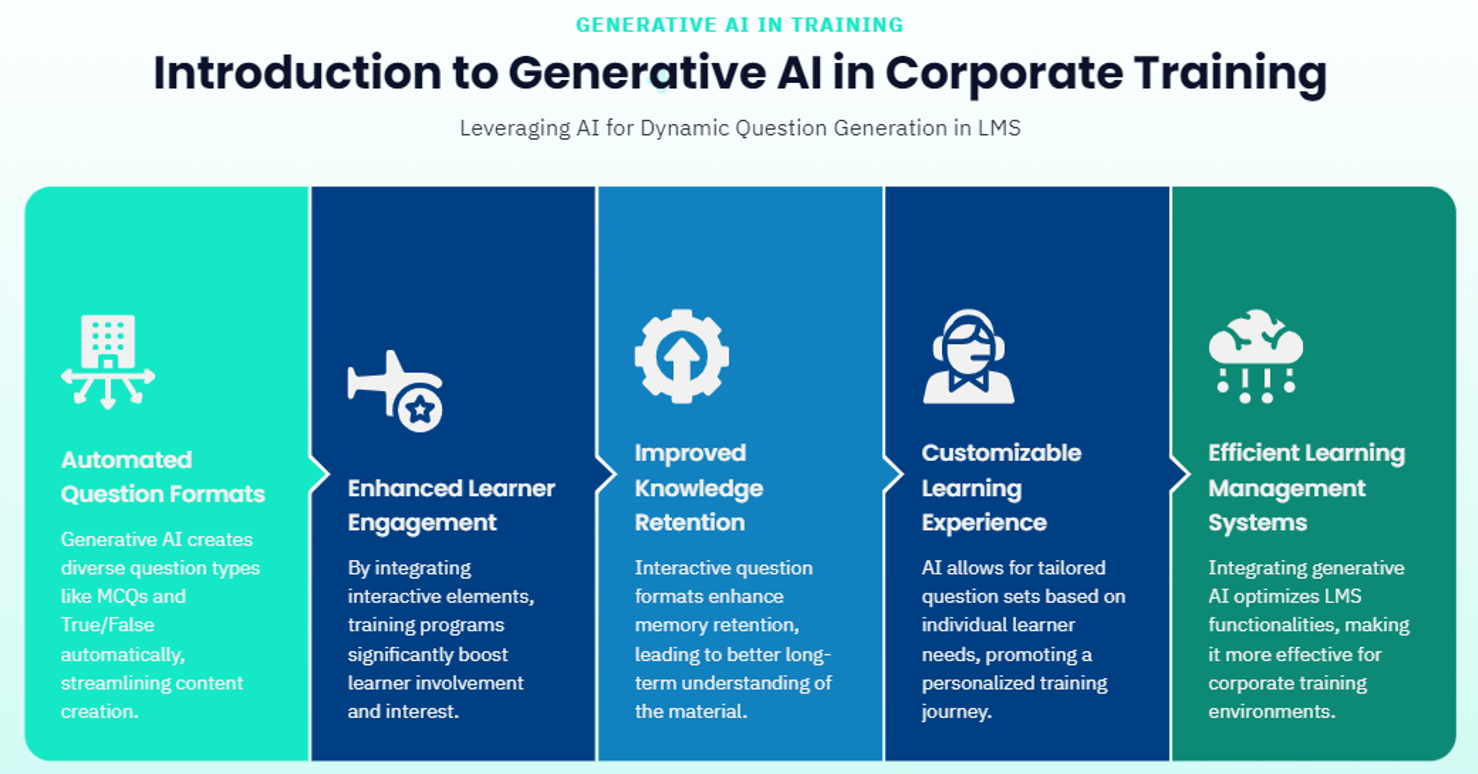

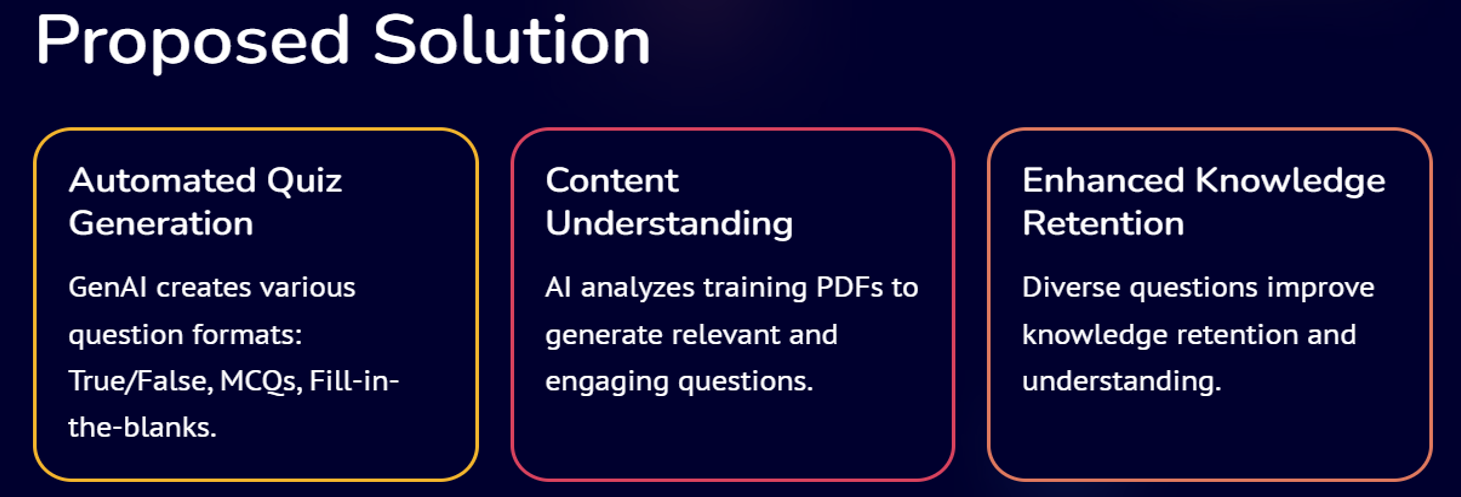

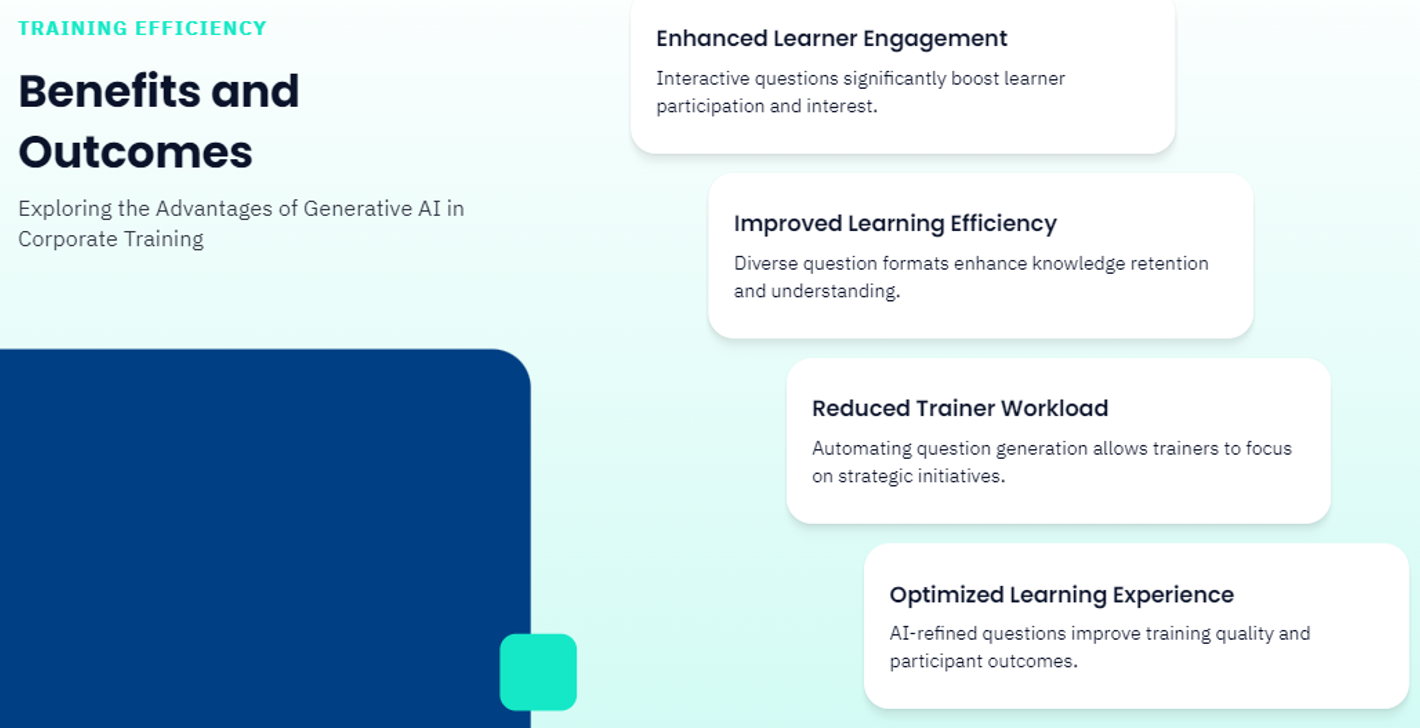

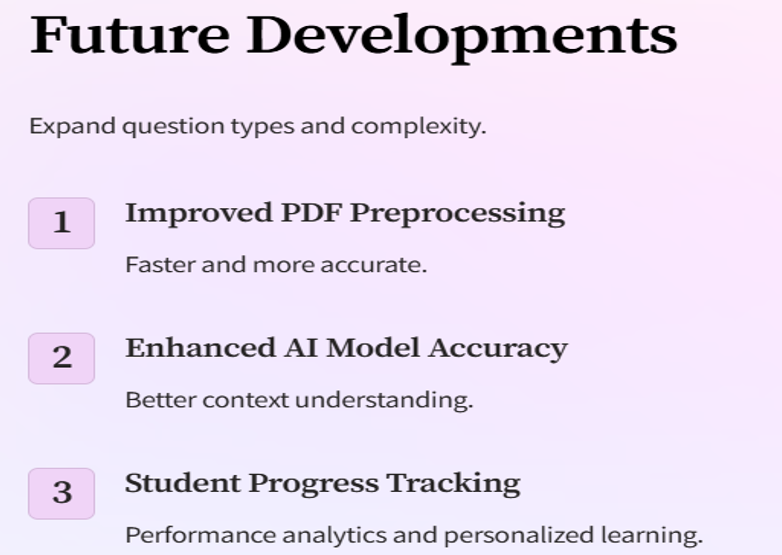

### TOPICS

### PDF Preprocessing : extract text and clean

Fitz (pymupdf) is faster than pdfminer, also it is very good in text extraction. However it also fails to extract text from some pages properly, so we use pdfminer and combine the results.

pip install pymupdf (not fitz)
pip install pdfminer.six (in root only)

In [68]:
import pandas as pd
import pymupdf
import pdfminer
import pdfminer.high_level

import time
start_time = time.time()


Test : working of Fitz

In [69]:

def check_fitz_pdf(pdf_file):
    import fitz

    # Open the PDF file
    doc = fitz.open(pdf_file)

    # Get the total page count
    page_count = len(doc)

    print(f"Total pages: {page_count}")

    # Select the page you want to read
    page = doc[45]

    # Extract the page content
    page_text = page.get_text()
    print(page_text)

    # Close the PDF file
    doc.close()

Get pdf data into data frame using Fitz

In [70]:
def get_pymupdf_data(pdf_file):
    df = pd.DataFrame(columns=['pg', 'Header', 'Footer', 'Contents'])
    #with open(pdf_file, 'rb') as f:
    with pymupdf.open(pdf_file) as doc:
        page_num = 0
        # Get the total page count
        page_count = len(doc)
        print("=======")
        print("nos of pages: ", page_count)
        print("pdf: ", pdf_file)
        print("=======")
        while page_num<page_count: 
            # page count is total nos of pages, starts from 1, where as page_num is index starting from 0
            # Select the page you want to read
            page = doc[page_num]
            page_num += 1
            # Extract the page content
            text = page.get_text()
            print(f"{page_num}, text: {text}")
            if not text:
                print("Not Text at page {page_num}") #starting page 1, not 0 as pgnum is already +1 incremented
                text = "" #not able to extract the page, so put just dummy text, so as to keep page nos in df intact.
                #continue

            # Extract header text
            header_text = ''
            for line in text.splitlines():
                if line.strip():  # ignore blank lines
                    header_text += line
                    break

            # Extract footer text
            footer_text = ''
            for line in reversed(text.splitlines()):
                if line.strip():  # ignore blank lines
                    footer_text += line
                    break

            
            # Create a new row for the DataFrame
            row = {'pg': page_num, 'Header': header_text, 'Footer': footer_text, 'Contents': text}
            df.loc[len(df)] = row

            print(f"Page {page_num}:")
            print("Header:", header_text)
            print("Footer:", footer_text)
            print()
 
            

    print(f"Extracted {page_num} pages")
    return df



Get pdf data into data frame using PDFminer

In [71]:
def get_pdfminer_data(pdf_file):
    df = pd.DataFrame(columns=['pg', 'Header', 'Footer', 'Contents'])
    with open(pdf_file, 'rb') as f:
        page_num = 0
        while True:
            text = pdfminer.high_level.extract_text(f, page_numbers=[page_num])

            if not text:
                break

            # Extract header text
            header_text = ''
            for line in text.splitlines():
                if line.strip():  # ignore blank lines
                    header_text += line
                    break

            # Extract footer text
            footer_text = ''
            for line in reversed(text.splitlines()):
                if line.strip():  # ignore blank lines
                    footer_text += line
                    break

            page_num += 1
            # Create a new row for the DataFrame
            row = {'pg': page_num, 'Header': header_text, 'Footer': footer_text, 'Contents': text}
            df.loc[len(df)] = row

            print(f"Page {page_num}:")
            print("Header:", header_text)
            print("Footer:", footer_text)
            print()
 
            

    print(f"Extracted {page_num} pages")
    return df

Fitz takes little more time compared to Pdfminer.

Function to remove special charectors, but not useful for LLM use case.

In [72]:
import re

def pdfPreproc1_remove_special_chars(df):
    """
    Remove special characters like \x0c from a PDF file
    '\x0c' was found in a blank sheet.
    """
    # Use regular expression to match and remove special characters
    pattern = r'[\x00-\x1F\x7F]'  # matches ASCII control characters
    df['Contents'] = df['Contents'].apply(lambda x: re.sub(pattern, ' ', x).strip() )
    # replace wit a space, but if the contents is blank, strip makes it ''
    return df


Get Chapter information from 1st line or last line (Header & Footer)

In [73]:
def pdfPreproc2_chapter_from_footer_header(df):
    df['Chapter'] = ''

    for index, row in df.iterrows():
        if 'chapter' in row['Footer'].lower():
            df.at[index, 'Chapter'] = row['Footer']
        elif 'chapter' in row['Header'].lower():
            df.at[index, 'Chapter'] = row['Header']
        else:
            df.at[index, 'Chapter'] = ''  # or some default value
    return df

Get the missing Chapter information from the adjacent pages, if adjacent pages have same Chapter

In [74]:
def pdfPreproc3_chapter_if_adjacent_same(df):
    changed_count = 0
    changed_values = []

    for index, row in df.iterrows():
        if row['Chapter'] == '':
            # Check adjacent rows
            prev_row = df.iloc[index-1] if index > 0 else None
            next_row = df.iloc[index+1] if index < len(df) - 1 else None

            if prev_row is not None and next_row is not None and prev_row['Chapter'] is not None and next_row['Chapter'] is not None and prev_row['Chapter'].lower() == next_row['Chapter'].lower():
                df.at[index, 'Chapter'] = prev_row['Chapter']
                changed_count += 1
                changed_values.append((index, prev_row['Chapter']))

    #print(f"Changed {changed_count} rows ")
    #print("Changed values:", changed_values)
    return df

Chapter from previous page, if next page is empty

In [75]:
#if Chapter is blank, if next page contents & chapter is blank, means this page belongs to previous chapter.
def pdfPreproc14_chapter_if_next_empty(df):
    # create a mask to identify rows where Chapter is empty
    mask = df['Chapter'] == ''

    # create a mask to identify rows where Contents is not empty
    contents_mask = df['Contents'] != ''

    # create a mask to identify rows where next page's Contents is empty
    next_page_mask = df['Contents'].shift(-1) == ''

    # fill in the Chapter values according to the rule
    df.loc[mask & contents_mask & next_page_mask, 'Chapter'] = df['Chapter'].shift(1)
    return df

Combine the preprocessing  functions

In [76]:
def preproc(df):
 #for df in [df1_fitz, df1_pdfminer]: # can put n nos of df in the array
    #pdfPreproc1_remove_special_chars(df) # seems special chars r needed for future topic analysis
    df = pdfPreproc2_chapter_from_footer_header(df)
    df = pdfPreproc3_chapter_if_adjacent_same(df)
    df = pdfPreproc14_chapter_if_next_empty(df)
    return df


In [77]:
def show_df(df, start, stop):
    for pgindex in range(start,stop):
        print("Page Index: ", pgindex)
        print(f"Header:  {df.iloc[pgindex]['Header']}")
        print(f"Footer:  {df.iloc[pgindex]['Footer']}")
        print(f"Chapter: {df.iloc[pgindex]['Chapter']}")
        print(f"Contents: {df.iloc[pgindex]['Contents']}")
        print("----")
        print("")

OBSERVATION of Fitz df: 

1. Here the footer comes first. In all over this pdf (Fabio), the header and footer are interchanged. 

2. Some footer has chapter information, but the Chapter# of DF is not getting updated

Page Index:  18

Header:  1

Footer:  possible responses of these systems and their evolution in time.

Chapter: 

Contents: 1 © Fabio Nelli 2018  F. Nelli, Python Data Analytics, https://doi.org/10.1007/978-1-4842-3913-1_1 CHAPTER 1 An Introduction to 



display where Chapter is blank 

In [78]:
def show_nil_chapter(df):
    nil_chapter_pages = df[df['Chapter'] == '']
    print("Total nos of pages with nil Chapter#: ", len(nil_chapter_pages))
    print("----------------")
    for index, row in nil_chapter_pages.iterrows():
        print("Page Index: ", index)
        print(f"Header:  {row['Header']}")
        print(f"Footer:  {row['Footer']}")
        print(f"Chapter: {row['Chapter']}")
        print(f"Contents: {row['Contents']}")
        print("----")
        print("")

the blank Chapter means, could be TOC, Author, Appendix, Index etc. 
But in one case (index 455, pdf page 443), there is a blank. The next chapter is 11, previous is 10. Interesting part is the chapter is given as footer but the pdf parser is not reading it.

Club the two DF, for some rows in Fitz with no chapter details, same rows in pdfminer has those and vice versa. But mostly Fitz is fast so keep it as main.


In [79]:
def update_fitz_chapter_from_pdfminer(df_fitz, df_pdfminer):

    # Assuming df1_fitz and df1_pdfminer are your two DataFrames

    # Find all occurrences where either or both DFs have nothing in the Chapter column
    empty_chapters_fitz = df_fitz[df_fitz['Chapter'].isna() | df_fitz['Chapter'].eq('')]
    empty_chapters_pdfminer = df_pdfminer[df_pdfminer['Chapter'].isna() | df_pdfminer['Chapter'].eq('')]

    print("Rows with empty Chapter in df1_fitz:", len(empty_chapters_fitz))
    print(empty_chapters_fitz.index)
    print("Rows with empty Chapter in df1_pdfminer:", len(empty_chapters_pdfminer))
    print(empty_chapters_pdfminer.index)

    # Import the Chapter column of df1_pdfminer into df1_fitz and rename as 'temp'
    df_fitz['temp'] = df_pdfminer['Chapter']
    df_fitz['temp'] = df_fitz['temp'].fillna("") #otherwise it becomes na, now string
    df_fitz[(df_fitz['Chapter'] == "") & (df_fitz['temp'] == "")]
    return df_fitz

Combine the above functions for both Fitz & PdfMiner

In [80]:
pdf_file = 'P2_few_Python_Data_Analytics_Fabio.pdf'
def combined_func(pdf_file):
    df_fitz = get_pymupdf_data(pdf_file)
    print("pdf pages -  Fitz1: ", len(df_fitz))
    df_fitz = preproc(df_fitz)
    print("pdf pages -  Fitz2: ", len(df_fitz))
    df_fitz[(df_fitz['Chapter'] != "")]

    #for the rows where the column Chapter is'Chapter' exactly, remove it. Means if no Chapter number or details.
    df_fitz.loc[df_fitz['Chapter'].str.lower().str.strip().str.match('^chapter$'), 'Chapter'] = ""

    df_pdfminer = get_pdfminer_data(pdf_file)
    print("pdf pages -  Pdfminer1: ", len(df_pdfminer))
    df_pdfminer = preproc(df_pdfminer)
    print("pdf pages -  Pdfminer2: ", len(df_pdfminer))
    df_pdfminer[(df_pdfminer['Chapter'] != "")]
    df_final = update_fitz_chapter_from_pdfminer(df_fitz, df_pdfminer)
    df_final.loc[(df_final['Chapter'] == "") & (df_final['temp'] != ""), 'Chapter'] = df_final['temp']
    df_final.fillna("", inplace=True)
    #for the rows where the column Header is "Table of Contents" exactly, remove it. Means not Chapter, so keep Chapter as blank for now .
    df_final.loc[df_final['Header'].str.lower().str.strip().str.match('^table of contents$'), 'Chapter'] = ""
    df_final.loc[df_final['Footer'].str.lower().str.strip().str.match('^table of contents$'), 'Chapter'] = ""

    return df_final

In [81]:
#combined_func(pdf_file)
pymupdf.open(pdf_file)

Document('P2_few_Python_Data_Analytics_Fabio.pdf')

Example : 'Chapter 1' is found in some pages but 'Chapter 1 : Details' is common, so the 1st one is prefix of later, so replace with later.

In [82]:
def update_prefix_chapters(df):
 
    unique_chapters = df['Chapter'].value_counts()[df['Chapter'].value_counts() == 1].index
    print("Unique Chapters:", len(unique_chapters))
    print(df[df['Chapter'].isin(unique_chapters)])
    print("============")
    for index, row in df.iterrows():
        chapter = row['Chapter']
        if df['Chapter'].value_counts()[chapter] == 1:  # Check if Chapter is unique
            next_page_index = index + 1
            if next_page_index < len(df):
                next_chapter = df.iloc[next_page_index]['Chapter']
                if chapter.lower() in next_chapter.lower()[:len(chapter)]:
                    df.at[index, 'Chapter'] = next_chapter
                    print(f"Replaced {chapter} with {next_chapter}")
                else:
                    print(f"{chapter} is NOT a PREFIX of {next_chapter} in the next page")
            else:
                print(f"No next page for {chapter}")
    print("---------")
    unique_chapters = df['Chapter'].value_counts()[df['Chapter'].value_counts() == 1].index
    print("Final Unique Chapters:", len(unique_chapters))
    return df

If combined DF still has missing Chapter information...

In [83]:
def update_nil_chapter_with_adjacent_if_same(df):
    unique_chapters = df['Chapter'].value_counts()[df['Chapter'].value_counts() == 1].index

    for chapter in unique_chapters:
        chapter_index = df[df['Chapter'] == chapter].index[0]
        prev_chapter_index = chapter_index - 1
        next_chapter_index = chapter_index + 1
        
        if prev_chapter_index >= 0:
            prev_chapter = df.iloc[prev_chapter_index]['Chapter']
            print(f"Previous Chapter for {chapter} is {prev_chapter}")
        else:
            print(f"No previous Chapter for {chapter}")
        
        if next_chapter_index < len(df):
            next_chapter = df.iloc[next_chapter_index]['Chapter']
            print(f"Next Chapter for {chapter} is {next_chapter}")
        else:
            print(f"No next Chapter for {chapter}")
        
        if prev_chapter_index >= 0 and next_chapter_index < len(df):
            if prev_chapter == next_chapter:
                df.at[chapter_index, 'Chapter'] = prev_chapter
                print(f"Replaced {chapter} with {prev_chapter}")
    return df

In [84]:
get_pdfminer_data(pdf_file)

Page 1:
Header: Python Data 
Footer: Fabio Nelli

Page 2:
Header: Python Data Analytics
Footer: Fabio Nelli

Page 3:
Header: Python Data Analytics
Footer: Printed on acid-free paper

Page 4:
Header: Table of Contents
Footer: v

Page 5:
Header: Table of ConTenTs
Footer: vi

Page 6:
Header: Table of ConTenTs
Footer: vii

Page 7:
Header: Table of ConTenTs
Footer: viii

Page 8:
Header: About the Technical Reviewer
Footer: xix

Page 9:
Header: CHAPTER 1
Footer: 1

Page 10:
Header: Chapter 1 
Footer: 2

Page 11:
Header: F
Footer: 559

Page 12:
Header: Index
Footer: Hebrew, 541

Page 13:
Header: lowercase Greek, 540
Footer: 561

Page 14:
Header: Index
Footer: downloader tool, 489

Page 15:
Header: fileids() function, 491
Footer: 563

Extracted 15 pages


,pg,Header,Footer,Contents
0,1,Python Data,Fabio Nelli,"Python Data \nAnalytics\n\nWith Pandas, NumPy,..."
1,2,Python Data Analytics,Fabio Nelli,"Python Data Analytics\n\nWith Pandas, NumPy, ..."
2,3,Python Data Analytics,Printed on acid-free paper,"Python Data Analytics\n\nFabio Nelli\nRome, It..."
3,4,Table of Contents,v,Table of Contents\n\nAbout the Author ��������...
4,5,Table of ConTenTs,vi,Table of ConTenTs\n\nChapter 2: Introduction ...
5,6,Table of ConTenTs,vii,"Table of ConTenTs\n\nIndexing, Slicing, and It..."
6,7,Table of ConTenTs,viii,Table of ConTenTs\n\nThe DataFrame �����������...
7,8,About the Technical Reviewer,xix,About the Technical Reviewer\n\nRaul Samayoa i...
8,9,CHAPTER 1,1,CHAPTER 1\n\nAn Introduction to \nData Analys...
9,10,Chapter 1,2,Chapter 1 \n\n an IntroduCtIon to data analysI...


In [85]:
df1_final = combined_func(pdf_file)
df1_final = update_prefix_chapters(df1_final)
df1_final = update_nil_chapter_with_adjacent_if_same(df1_final)

nos of pages:  15
pdf:  P2_few_Python_Data_Analytics_Fabio.pdf
1, text: Python Data 
Analytics
With Pandas, NumPy, and Matplotlib
—
Second Edition
—
Fabio Nelli

Page 1:
Header: Python Data 
Footer: Fabio Nelli

2, text: Python Data Analytics
With Pandas, NumPy,  
and Matplotlib
Second Edition
Fabio Nelli

Page 2:
Header: Python Data Analytics
Footer: Fabio Nelli

3, text: Python Data Analytics
ISBN-13 (pbk): 978-1-4842-3912-4	
	
	
	
ISBN-13 (electronic): 978-1-4842-3913-1
https://doi.org/10.1007/978-1-4842-3913-1
Library of Congress Control Number: 2018957991
Copyright © 2018 by Fabio Nelli
This work is subject to copyright. All rights are reserved by the Publisher, whether the whole or part of the 
material is concerned, specifically the rights of translation, reprinting, reuse of illustrations, recitation, 
broadcasting, reproduction on microfilms or in any other physical way, and transmission or information 
storage and retrieval, electronic adaptation, computer software, or by sim

In [86]:
df1_final

,pg,Header,Footer,Contents,Chapter,temp
0,1,Python Data,Fabio Nelli,"Python Data \nAnalytics\nWith Pandas, NumPy, a...",,
1,2,Python Data Analytics,Fabio Nelli,"Python Data Analytics\nWith Pandas, NumPy, \n...",,
2,3,Python Data Analytics,"Rome, Italy",Python Data Analytics\nISBN-13 (pbk): 978-1-48...,,
3,4,v,.................................................,v\nAbout the Author.............................,,
4,5,vi,Table of Contents,vi\nChapter 2: \nIntroduction to the Python ...,,
5,6,vii,Table of Contents,"vii\nIndexing, Slicing, and Iterating\n.........",,
6,7,viii,Table of Contents,viii\nThe DataFrame.............................,,
7,8,xix,"coders, and likes to work with data in Python ...",xix\nAbout the Technical Reviewer\nRaul Samayo...,,
8,9,1,possible responses of these systems and their ...,"1\n© Fabio Nelli 2018 \nF. Nelli, Python Data ...",Chapter 1 An Introduction to Data Analysis,CHAPTER 1
9,10,2,Chapter 1 An Introduction to Data Analysis,2\nStarting from a simple methodical approach ...,Chapter 1 An Introduction to Data Analysis,Chapter 1


Write to CSV

In [87]:
#df1_final.drop('temp', axis=1, inplace=True)
df1_final.to_csv("P2_Sel2.csv", index=False)


### Data Wrangling : Organize the text into Chunks, take text only from Chapter contents

Run from here for LLM QA gen

In [88]:
import pandas as pd
def read_csv_to_df(csv_file):
    df = pd.read_csv(csv_file)
    df.fillna("", inplace=True)
    df.drop('temp', axis=1, inplace=True) #keep temp only incase any mess up with chapters
    df.head(20)
    return df

In [89]:
csv_file = "P2_Sel2.csv"
df1_read = read_csv_to_df(csv_file)



In [90]:
df1_read

,pg,Header,Footer,Contents,Chapter
0,1,Python Data,Fabio Nelli,"Python Data \nAnalytics\nWith Pandas, NumPy, a...",
1,2,Python Data Analytics,Fabio Nelli,"Python Data Analytics\nWith Pandas, NumPy, \n...",
2,3,Python Data Analytics,"Rome, Italy",Python Data Analytics\nISBN-13 (pbk): 978-1-48...,
3,4,v,.................................................,v\nAbout the Author.............................,
4,5,vi,Table of Contents,vi\nChapter 2: \nIntroduction to the Python ...,
5,6,vii,Table of Contents,"vii\nIndexing, Slicing, and Iterating\n.........",
6,7,viii,Table of Contents,viii\nThe DataFrame.............................,
7,8,xix,"coders, and likes to work with data in Python ...",xix\nAbout the Technical Reviewer\nRaul Samayo...,
8,9,1,possible responses of these systems and their ...,"1\n© Fabio Nelli 2018 \nF. Nelli, Python Data ...",Chapter 1 An Introduction to Data Analysis
9,10,2,Chapter 1 An Introduction to Data Analysis,2\nStarting from a simple methodical approach ...,Chapter 1 An Introduction to Data Analysis


2024.07.20 Seems TOC has come inside Chapter. Also CHAPTER \n1 is not recognized as Chapter 1

In [91]:
print(df1_read.iloc[4]['Chapter'])
print(df1_read.iloc[5]['Header'])
df1_read.iloc[5]['Footer']


vii


'Table of Contents'

Show the Chapter nos etc.

In [92]:
chapter_value_counts = df1_read['Chapter'].value_counts().sort_index()
print(chapter_value_counts)

Chapter
                                                13
Chapter 1  An Introduction to Data Analysis      2
Name: count, dtype: int64


Observed that the 1st row in the above result, is blank Chapter.

For Chapter is nothing, show details

In [93]:
no_chapter_rows = df1_read[df1_read['Chapter']==""]
print(no_chapter_rows[['pg','Footer']])

    pg                                             Footer
0    1                                        Fabio Nelli
1    2                                        Fabio Nelli
2    3                                        Rome, Italy
3    4  .................................................
4    5                                  Table of Contents
5    6                                  Table of Contents
6    7                                  Table of Contents
7    8  coders, and likes to work with data in Python ...
10  11                                              Index
11  12                                              Index
12  13                                              Index
13  14                                              Index
14  15                                              Index


Function to combine contents of df, of same chapter. Now each row will be of a chapter with all pages of it joined together and carrying the 1st page# of the chapter in pg column, so that it can be sorted Chapter wise ( else the Chapter 10 comes after Chapter 1)

In [94]:
import math
def make_df_chapters(df):
    #combine contents of each chapter so we get chapter wise.
    df_only_chapters = df[df['Chapter'] != ''].copy()
    df_chapters = df_only_chapters.groupby('Chapter')['Contents'].agg(lambda x: ' '.join(x)).reset_index()
    df_chapters['pg'] = df_chapters['Chapter'].transform(lambda x: df_only_chapters[df_only_chapters['Chapter'] == x]['pg'].min())
    df_chapters = df_chapters.sort_values(by='pg')
    df_chapters['token_count'] = df_chapters['Contents'].apply(lambda x: math.ceil(len(x.split()) * 1.25)) #token count is 25% higher than word count

    return df_chapters

Copy to new df, the Chapter, Pg, Contents, TokenCount

In [95]:
df1_chapters = make_df_chapters(df1_read)
df1_chapters.reset_index(inplace=True,  drop=True)
df1_chapters

,Chapter,Contents,pg,token_count
0,Chapter 1 An Introduction to Data Analysis,"1\n© Fabio Nelli 2018 \nF. Nelli, Python Data ...",9,952


Confirm no none chapter exists

In [96]:
no_chapter_rows = df1_chapters[df1_chapters['Chapter']==""]
print(no_chapter_rows[['pg','Chapter']])

Empty DataFrame
Columns: [pg, Chapter]
Index: []


Chunking

Chunking : Split on sentences, overlap the last sentence.

In [97]:

# Function to split content into chunks
def chunk_content(content, token_size, overlap):
  chunks = []
  current_chunk = ""
  prev_sentence = ""
  content = content.replace('.\n', '. \n') #this ensures proper split at full stop
  for sentence in content.split(". "):
    if len(current_chunk + ". " + sentence) <= token_size:
      current_chunk = current_chunk + ". " + sentence
      prev_sentence = sentence
    else:
      chunks.append(current_chunk+ ". ")
      current_chunk = prev_sentence + ". " + sentence
      prev_sentence = ""
  chunks.append(current_chunk)
  return chunks


In [98]:
df1_chapters['chunked_contents'] = df1_chapters['Contents'].apply(lambda x: chunk_content(x, token_size=1500, overlap=20))


Show chunks of the first chapter

In [99]:
df1_chapters.iloc[0]['chunked_contents']

['. 1\n© Fabio Nelli 2018 \nF. Nelli, Python Data Analytics, https://doi.org/10.1007/978-1-4842-3913-1_1\nCHAPTER 1\nAn Introduction to\xa0 \nData Analysis\nIn this chapter, you begin to take the first steps in the world of data analysis, learning in \ndetail about all the concepts and processes that make up this discipline. The concepts \ndiscussed in this chapter are helpful background for the following chapters, where these \nconcepts and procedures will be applied in the form of Python code, through the use of \nseveral libraries that will be discussed in just as many chapters. \n\x07\nData Analysis\nIn a world increasingly centralized around information technology, huge amounts of \ndata are produced and stored each day. Often these data come from automatic detection \nsystems, sensors, and scientific instrumentation, or you produce them daily and \nunconsciously every time you make a withdrawal from the bank or make a purchase, \nwhen you record various blogs, or even when you po

Show all chunks

In [100]:
def Show_Chunks(df):
 for index, row in df.iterrows():
    chunked_contents = row['chunked_contents']
    print("-----------------------------")
    print("nos of chunks: ", len(chunked_contents))
    for chunk in chunked_contents:
        print("Chunk len: ", len(chunk))
        print(f"Chapter {index+1}: {chunk}")
        print()
 

In [101]:
Show_Chunks(df1_chapters)

-----------------------------
nos of chunks:  4
Chunk len:  1486
Chapter 1: . 1
© Fabio Nelli 2018 
F. Nelli, Python Data Analytics, https://doi.org/10.1007/978-1-4842-3913-1_1
CHAPTER 1
An Introduction to  
Data Analysis
In this chapter, you begin to take the first steps in the world of data analysis, learning in 
detail about all the concepts and processes that make up this discipline. The concepts 
discussed in this chapter are helpful background for the following chapters, where these 
concepts and procedures will be applied in the form of Python code, through the use of 
several libraries that will be discussed in just as many chapters. 

Data Analysis
In a world increasingly centralized around information technology, huge amounts of 
data are produced and stored each day. Often these data come from automatic detection 
systems, sensors, and scientific instrumentation, or you produce them daily and 
unconsciously every time you make a withdrawal from the bank or make a purchase, 

df1:

\n\x07\n = Paragraph break.

\n = line break


Now the df (eg df1_chapters), has a column 'chunked_contents' which contains the array of chunks for each chapter.
To get the 1st chapter chunks :- df2_chapters.iloc[0]['chunked_contents']

In [102]:
end_time = time.time()
execution_time_preproc = end_time - start_time
start_time = time.time()

### Gemini API - QAG (Question Answer Generation) from chunks of pdf

Test the Gemini API - Hello World example (add API Key)

In [ ]:
import json

GOOGLE_API_KEY = ""

import google.generativeai as genai

def test_gemini():
    genai.configure(api_key=GOOGLE_API_KEY)
    model = genai.GenerativeModel('gemini-pro')
    response = model.generate_content("Write me a poem")
    print(response.text)

In [ ]:
def test_gemini2():
    # Configure with your Google API Key
    genai.configure(api_key=GOOGLE_API_KEY)

  
    text_passage = df1_chapters.iloc[0]['chunked_contents'][0]
    #print(text_passage)
    # Craft a prompt that guides Gemini towards question generation
    prompt = f"Can you generate some relevent questions from it?"

    # Use the generic generate_content method
    model = genai.GenerativeModel('gemini-pro')
    response = model.generate_content(prompt + "\n" + text_passage)

    # Print the generated questions (may require further processing)
    print(response.text)


Try BASIC prompt engineering for Diverse QA generation

In [105]:
def basic_prompt():

    # Assuming you have your text passage stored in a variable called 'text_passage'

    text_passage = ""
    prompt = f"""

    **Instructions:** Based on the passage, generate the following types of questions and answers:

    1. **Fill in the Blanks:** Create questions with blanks where the answer completes the sentence logically. Provide the actual answer for referance.
    2. **Match the Following:** Provide a list of terms from the passage and a matching list of descriptions.  Provide the actual answer for referance.
    3. **Multiple Choice Questions (MCQ):** Formulate questions with answer choices, where only one choice is the correct answer based on the passage.  Provide actual answer for referance.
    4. **True or False:** Generate statements related to the passage and mark them as True or False.  Provide the actual answer for referance.

    **Passage:**

    {text_passage}
    """

    # Use your preferred method (e.g., genai.GenerativeModel.generate_content) to process the prompt


In [106]:
import google.generativeai as genai
def get_Gemini_response(chunk, prompt, GOOGLE_API_KEY):
    
    # Configure with your Google API Key
    genai.configure(api_key=GOOGLE_API_KEY)

    model = genai.GenerativeModel('gemini-pro')
    response = model.generate_content(prompt + "\n" + chunk)

    # Print the generated questions (may require further processing)
    print("Response.text")
    print(response.text)
    print("----------------------------------------")
    print("")
    return response.text


In [107]:
def test_gemini3():
    chunk = df1_chapters.iloc[0]['chunked_contents'][0]
    get_Gemini_response(chunk, prompt, GOOGLE_API_KEY)

The above result is not in csv or json format.

### Better PROMPT Engineering for our use case.
The whole response should be inside json, else difficult to parse/ make Tabular


In [108]:
def prompt2():
    text_passage = ""
    prompt = f"""

    **Instructions:** Based on the passage, generate the following types of questions and answers and send each inside  json format. The whole response should be inside json and this is mandatory.

    1. **Fill in the Blanks:** Create questions with blanks where the answer completes the sentence logically. Provide question, actual answer for referance. All in json format.
    2. **Match the Following:** Provide a list of concepts from the passage and a matching list of descriptions.  Provide question, options, actual answer for referance. All in json format.
    3. **Multiple Choice Questions (MCQ):** Formulate questions with answer choices, where only one choice is the correct answer based on the passage.  Provide question, options, actual answer for referance. All in json format.
    4. **True or False:** Generate statements related to the passage and mark them as True or False.  Provide question, options, actual answer for referance. All in json format.

    **Passage:**

    {text_passage}
    """

    responseTxt = get_Gemini_response(chunk, prompt, GOOGLE_API_KEY)


Testing with Dummy Json

In [109]:
import json

dummyjsonTxt = '''{

  "Fill in the Blanks": [

    {

      "question": "The first ML application that really became mainstream and improved the lives of millions was the _____.",

      "answer": "spam filter"

    },

    {

      "question": "According to most people, Machine Learning is a _____.",

      "answer": "robot"

    }

  ],

  "Match the Following": [

    {

      "concept": "Optical Character Recognition (OCR)",

      "description": "A specialized application of Machine Learning that has been around for decades"

    },

    {

      "concept": "Spam filter",

      "description": "The first mainstream Machine Learning application that improved the lives of many"

    }

  ],

  "Multiple Choice Questions": [

    {

      "question": "Which of the following is NOT an example of a product or feature that uses Machine Learning?",

      "choices": [

        "Recommendations",

        "Voice search",

        "GPS navigation",

        "Spam filtering"

      ],

      "answer": "GPS navigation"

    },

    {

      "question": "What is the main purpose of Chapter 1?",

      "choices": [

        "To explain what Machine Learning is and why you may want to use it",

        "To give a historical overview of Machine Learning",

        "To provide examples of different Machine Learning applications",

        "To discuss the ethical implications of Machine Learning"

      ],

      "answer": "To explain what Machine Learning is and why you may want to use it"

    }

  ],

  "True or False": [

    {

      "statement": "Machine Learning only exists in futuristic fantasies.",

      "answer": "False"

    },

    {

      "statement": "Spam filtering is technically considered Machine Learning.",

      "answer": "True"

    }

  ]

}'''



Parsing with dummy Json

In [110]:
def parse_json(jsonTxt):
  json_data = json.loads(jsonTxt)

  for category, data in json_data.items():
    print(f"\nCategory: {category}")

    if category == "Fill in the Blanks":
      for item in data:
        print(f"Question: {item['question']}")
        print(f"Answer: {item['answer']}")

    elif category == "Match the Following":
      for item in data:
        print(f"concept: {item['concept']}")
        print(f"Description: {item['description']}")

    elif category == "Multiple Choice Questions":
      for item in data:
        print(f"Question: {item['question']}")
        choices = item["choices"]
        for idx, choice in enumerate(choices):
          print(f"{idx+1}. {choice}")
        print(f"Answer: {item['answer']}")

    elif category == "True or False":
      for item in data:
        print(f"Statement: {item['statement']}")
        print(f"Answer: {item['answer']}")

    else:
      print(f"Unrecognized category: {category}")

  print("\nParsing completed!")

In [111]:
#parse_json(dummyjsonTxt)

Final Prompt & combined functions to create diverse QA from DF

In [112]:
prompt_final = """{
  "instructions": "Based on the passage, generate the following types of questions and answers and send each inside json format. 
  The whole response should be inside json and this is mandatory. 
  The Type should exactly be same as mentioned in this prompt",
  "tasks": [
    {
      "type": "Blanks",
      "description": "Create questions with blanks where the answer completes the sentence logically. Provide question, actual answer for reference. All in json format."
    },
    {
      "type": "Match",
      "description": "Provide a list of concepts from the passage and a matching list of descriptions. Provide  question, options, actual answer for reference. All in json format."
    },
    {
      "type": "MCQ",
      "description": "Formulate questions with answer choices, where only one choice is the correct answer based on the passage. Provide question, options, actual answer for reference. All in json format."
    },
    {
      "type": "True/False",
      "description": "Generate statements related to the passage and mark them as True or False. Provide question, options, actual answer for reference. All in json format."
    }
  ],
  "passage": 
}"""

def create_qa_from_chunk(chunk):
  responseTxt = get_Gemini_response(chunk, prompt_final, GOOGLE_API_KEY)
  #responseTxt = response.text
  responseTxt = responseTxt.replace("```json", "")
  responseTxt = responseTxt.replace("```", "").strip()
  #print(responseTxt)
  return responseTxt

In [113]:

def parse_json(responseTxt):
    json_obj = json.loads(responseTxt)

    # Accessing "Fill in the Blanks" questions
    for question in json_obj["Blanks"]:
        print(question["question"])
        print(question["answer"])

    # Accessing "Match the Following" questions
    match_question = json_obj["Match"][0]
    print(match_question["question"])
    for option in match_question["options"]:
        print(option["concept"])
        print(option["description"])

    # Accessing "Multiple Choice Questions" questions
    for question in json_obj["MCQ"]:
        print(question["question"])
        for option in question["options"]:
            print(option)
        print(question["answer"])

    # Accessing "True or False" questions
    for question in json_obj["True/False"]:
        print(question["question"])
        for option in question["options"]:
            print(option)
        print(question["answer"])

In [114]:
df1_chapters

,Chapter,Contents,pg,token_count,chunked_contents
0,Chapter 1 An Introduction to Data Analysis,"1\n© Fabio Nelli 2018 \nF. Nelli, Python Data ...",9,952,"[. 1\n© Fabio Nelli 2018 \nF. Nelli, Python Da..."


In [115]:
import json

def is_valid_json_old(json_string):
  """
  This function checks if the provided string is a valid JSON format.

  Args:
      json_string: The string to be evaluated for valid JSON format.

  Returns:
      True if the string is valid JSON, False otherwise.
  """
  try:
    json.loads(json_string)
  except (json.JSONDecodeError, TypeError) as e:
    return False
  return True




### Question Answers saved into DB

In [116]:
import sqlite3

def insert_data(data):
    try:
        conn = sqlite3.connect('quiz_database.db')
        cursor = conn.cursor()

        # Create tables
        create_tables(cursor)

        # Determine the format and insert data accordingly
        if 'tasks' in data:
            # Old format
            insert_old_format(cursor, data)
        else:
            # New format
            insert_new_format(cursor, data)

        conn.commit()
        print("Data inserted successfully.")
    except sqlite3.Error as e:
        print(f"An error occurred with the database: {e}")
    except KeyError as e:
        print(f"Missing key in data structure: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
    finally:
        if conn:
            conn.close()

def create_tables(cursor):
    tables = [
        '''CREATE TABLE IF NOT EXISTS blanks (
            id INTEGER PRIMARY KEY,
            question TEXT,
            answer TEXT
        )''',
        '''CREATE TABLE IF NOT EXISTS match_questions (
            id INTEGER PRIMARY KEY,
            question TEXT
        )''',
        '''CREATE TABLE IF NOT EXISTS match_options (
            id INTEGER PRIMARY KEY,
            question_id INTEGER,
            term TEXT,
            option TEXT,
            FOREIGN KEY (question_id) REFERENCES match_questions(id)
        )''',
        '''CREATE TABLE IF NOT EXISTS match_answers (
            id INTEGER PRIMARY KEY,
            question_id INTEGER,
            term TEXT,
            answer TEXT,
            FOREIGN KEY (question_id) REFERENCES match_questions(id)
        )''',
        '''CREATE TABLE IF NOT EXISTS mcq (
            id INTEGER PRIMARY KEY,
            question TEXT,
            correct_answer TEXT
        )''',
        '''CREATE TABLE IF NOT EXISTS mcq_options (
            id INTEGER PRIMARY KEY,
            question_id INTEGER,
            option TEXT,
            FOREIGN KEY (question_id) REFERENCES mcq(id)
        )''',
        '''CREATE TABLE IF NOT EXISTS true_false (
            id INTEGER PRIMARY KEY,
            question TEXT,
            answer TEXT
        )'''
    ]

    for table in tables:
        cursor.execute(table)

def insert_old_format(cursor, data):
    for task in data['tasks']:
        question_type = task['type']
        if question_type == 'Blanks':
            insert_blanks(cursor, task['questions'])
        elif question_type == 'Match':
            insert_match(cursor, task['questions'])
        elif question_type == 'MCQ':
            insert_mcq(cursor, task['questions'])
        elif question_type == 'True/False':
            insert_true_false(cursor, task['questions'])
        else:
            print(f"Unknown question type: {question_type}")

def insert_new_format(cursor, data):
    insert_blanks(cursor, data.get('Blanks', []))
    insert_match(cursor, data.get('Match', []))
    insert_mcq(cursor, data.get('MCQ', []))
    insert_true_false(cursor, data.get('True/False', []))

def insert_blanks(cursor, items):
    for item in items:
        cursor.execute('INSERT INTO blanks (question, answer) VALUES (?, ?)',
                       (item['question'], item['answer']))

def insert_match(cursor, items):
    for item in items:
        cursor.execute('INSERT INTO match_questions (question) VALUES (?)',
                       (item['question'],))
        question_id = cursor.lastrowid
        options = item.get('options', [])
        for option in options:
            concept = option.get('concept') or option.get('term')
            description = option.get('description') or option.get('options', [''])[0]
            cursor.execute('INSERT INTO match_options (question_id, term, option) VALUES (?, ?, ?)',
                           (question_id, concept, description))
        answers = item.get('answer', [])
        for answer in answers:
            concept = answer.get('concept') or answer.get('term')
            description = answer.get('description') or answer.get('answer')
            cursor.execute('INSERT INTO match_answers (question_id, term, answer) VALUES (?, ?, ?)',
                           (question_id, concept, description))

def insert_mcq(cursor, items):
    for item in items:
        cursor.execute('INSERT INTO mcq (question, correct_answer) VALUES (?, ?)',
                       (item['question'], item['answer']))
        question_id = cursor.lastrowid
        for option in item['options']:
            cursor.execute('INSERT INTO mcq_options (question_id, option) VALUES (?, ?)',
                           (question_id, option))

def insert_true_false(cursor, items):
    for item in items:
        cursor.execute('INSERT INTO true_false (question, answer) VALUES (?, ?)',
                       (item['question'], item['answer']))


In [117]:
def read_data():
    try:
        conn = sqlite3.connect('quiz_database.db')
        cursor = conn.cursor()

        print("Blanks Questions:")
        try:
            cursor.execute("SELECT * FROM blanks")
            for row in cursor.fetchall():
                print(f"Question: {row[1]}\nAnswer: {row[2]}\n")
        except sqlite3.Error as e:
            print(f"Error reading blanks questions: {e}")

        print("\nMatch Questions:")
        try:
            cursor.execute("SELECT * FROM match_questions")
            for row in cursor.fetchall():
                print(f"Question: {row[1]}")
                try:
                    cursor.execute("SELECT * FROM match_options WHERE question_id=?", (row[0],))
                    print("Options:")
                    for option in cursor.fetchall():
                        print(f"  {option[2]}: {option[3]}")
                except sqlite3.Error as e:
                    print(f"Error reading match options: {e}")
                
                try:
                    cursor.execute("SELECT * FROM match_answers WHERE question_id=?", (row[0],))
                    print("Answers:")
                    for answer in cursor.fetchall():
                        print(f"  {answer[2]}: {answer[3]}")
                except sqlite3.Error as e:
                    print(f"Error reading match answers: {e}")
                print()
        except sqlite3.Error as e:
            print(f"Error reading match questions: {e}")

        print("\nMCQ Questions:")
        try:
            cursor.execute("SELECT * FROM mcq")
            for row in cursor.fetchall():
                print(f"Question: {row[1]}")
                print(f"Correct Answer: {row[2]}")
                try:
                    cursor.execute("SELECT * FROM mcq_options WHERE question_id=?", (row[0],))
                    print("Options:")
                    for option in cursor.fetchall():
                        print(f"  - {option[2]}")
                except sqlite3.Error as e:
                    print(f"Error reading MCQ options: {e}")
                print()
        except sqlite3.Error as e:
            print(f"Error reading MCQ questions: {e}")

        print("\nTrue/False Questions:")
        try:
            cursor.execute("SELECT * FROM true_false")
            for row in cursor.fetchall():
                print(f"Question: {row[1]}\nAnswer: {row[2]}\n")
        except sqlite3.Error as e:
            print(f"Error reading true/false questions: {e}")

    except sqlite3.Error as e:
        print(f"Error connecting to the database: {e}")
    finally:
        if conn:
            conn.close()

In [118]:
def test_response():
    chunk = df1_chapters.iloc[0]["chunked_contents"][0]
    chunk
    print("---------------------------------------")
    responseTxt = create_qa_from_chunk(chunk)
    print(responseTxt)
    return responseTxt
responseTxt = test_response()
print(responseTxt)

---------------------------------------
Response.text
{
  "Blanks": [],
  "Match": [],
  "MCQ": [],
  "True/False": []
}
----------------------------------------

{
  "Blanks": [],
  "Match": [],
  "MCQ": [],
  "True/False": []
}
{
  "Blanks": [],
  "Match": [],
  "MCQ": [],
  "True/False": []
}


In [119]:
def is_response_valid_json(responseTxt):
    expected_keys = {"Blanks", "Match", "MCQ", "True/False"}

    if responseTxt is None:
        print("Error: Response is None")
        return False

    # Check if the input is a string and try to parse it as JSON
    if isinstance(responseTxt, str):
        try:
            responseTxt = json.loads(responseTxt)
        except json.JSONDecodeError:
            print("Error: Response is a string but not valid JSON")
            return False

    # Now responseTxt should be a dictionary, if it was valid JSON
    if not isinstance(responseTxt, dict):
        print(f"Error: Response is not a dictionary. Type: {type(responseTxt)}")
        return False

    if set(responseTxt.keys()) != expected_keys:
        print(f"Error: Response keys do not match expected keys. Found: {set(responseTxt.keys())}")
        return False

    if all(not isinstance(responseTxt[key], list) or len(responseTxt[key]) == 0 for key in expected_keys):
        print("Error: All response lists are empty")
        return False

    return True

In [120]:
#is_response_valid_json(responseTxt)

In [121]:
responseTxt_JSON = json.loads(responseTxt)
insert_data(responseTxt_JSON)

Data inserted successfully.


In [122]:
import time

def create_qa_with_retry(chunk, max_attempts=7, delay=1):
    attempts = 0
    while attempts < max_attempts:
        try:
            responseTxt = create_qa_from_chunk(chunk)
            print("This was the response -----------------") 
            print(responseTxt)
            if is_response_valid_json(responseTxt):
                return responseTxt
            
        except Exception as e:
            print(f"Error occurred while creating QA: {str(e)}")
        
        attempts += 1
        print(f"Attempt {attempts} failed. Retrying in {delay} seconds...")
        time.sleep(delay)
    
    print(f"Failed to create valid QA after {max_attempts} attempts.")
    return None



In [123]:
def test_retry():
    result = create_qa_with_retry(chunk)

    if result is not None:
        print("Successfully created QA:")
        print(result)
    else:
        print("Failed to create QA. Please check the input or try again later.")


In [124]:
#test_retry()

In [125]:
def Generate_QA_Store_all_Chunks_firstCh_sql(df_Chapter):

  #for index, row in df1_chapters.iterrows():
  chapter = df_Chapter.iloc[0]["Chapter"] # 1st Chatper
  #chunks = row["chunked_contents"]
  chunks = df_Chapter.iloc[0]["chunked_contents"] # chunks of 1st Chatper
  # Print chapter details
  print(f"Chapter: {chapter}")
  
  # Print chunk details (assuming chunks is a list)
  i = 0
  for chunk in chunks:
    i += 1
    with open("_Chunk "+ str(i) + ".txt", "w") as f:
      f.write(chunk)
    print(f"\tChunk: {chunk}")
    #responseTxt = create_qa_from_chunk(chunk)
    print("================================")
    responseTxt = create_qa_with_retry(chunk)
    with open("_QA "+ str(i) + ".txt", "w") as f:
      f.write(responseTxt)
    #parse_json(responseTxt)
    if is_response_valid_json(responseTxt):
      responseTxt_JSON = json.loads(responseTxt)
      print("Storing to db, QA of Chunk: ", i)
      insert_data(responseTxt_JSON)
      print("================================")
    if i>=10:
      break
  # Print a separator for better readability (optional)
  print("-" * 20)


In [126]:
Generate_QA_Store_all_Chunks_firstCh_sql(df1_chapters)

Chapter: Chapter 1  An Introduction to Data Analysis 
	Chunk: . 1
© Fabio Nelli 2018 
F. Nelli, Python Data Analytics, https://doi.org/10.1007/978-1-4842-3913-1_1
CHAPTER 1
An Introduction to  
Data Analysis
In this chapter, you begin to take the first steps in the world of data analysis, learning in 
detail about all the concepts and processes that make up this discipline. The concepts 
discussed in this chapter are helpful background for the following chapters, where these 
concepts and procedures will be applied in the form of Python code, through the use of 
several libraries that will be discussed in just as many chapters. 

Data Analysis
In a world increasingly centralized around information technology, huge amounts of 
data are produced and stored each day. Often these data come from automatic detection 
systems, sensors, and scientific instrumentation, or you produce them daily and 
unconsciously every time you make a withdrawal from the bank or make a purchase, 
when you reco

In [127]:
end_time = time.time()
execution_time_qa_gen = end_time - start_time

print(f"Execution time for pdf prepro: {round(execution_time_preproc)} seconds")
print(f"Execution time for QA generation: {round(execution_time_qa_gen)} seconds")
print(f"Execution time total: {round(execution_time_qa_gen + execution_time_preproc)} seconds")


Execution time for pdf prepro: 2 seconds
Execution time for QA generation: 52 seconds
Execution time total: 54 seconds


### Question Answers read from DB

In [128]:
# Usage
read_data()

Blanks Questions:
Question: The process of extracting information from raw data is called __________.
Answer: data analysis

Question: The aim of data analysis is to extract information that is __________.
Answer: not easily deducible

Question: The model is the __________ of a system placed under study into a mathematical form.
Answer: translation

Question: The search for data, their extraction, and their subsequent preparation belong to __________.
Answer: data analysis

Question: The predictive power of a model depends on the __________ of the modeling techniques and the dataset.
Answer: quality


Match Questions:
Question: Match the following concepts with their descriptions:
Options:
  Data analysis: The process of extracting meaningful information from raw data
  Model: A mathematical representation of a system's responses
  Predictive power: The ability of a model to forecast future events
  Dataset: A collection of data upon which a model is built
Answers:
  Data analysis: The